# Projet Arbres de décision et Méthodes d'agrégations
-- Par Isaline Hervé - M2 ECAP --

# Importation des packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.stats as stats
from scipy.stats import chi2_contingency
import re
from sklearn.preprocessing import OneHotEncoder
from category_encoders.target_encoder import TargetEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.tree import plot_tree
from matplotlib import pyplot as plt


# Importation des données et premiers traitements
## Importation des données

In [2]:
df_train = pd.read_csv("./data/train.csv")
df_test = pd.read_csv("./data/test.csv")
df_train["__source__"] = "train"
df_test["__source__"] = "test"
df = pd.concat([df_train, df_test], axis=0, ignore_index=True)

df.info()
# 8868 lignes, 25 colonnes (sans compter la colonne source)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8868 entries, 0 to 8867
Data columns (total 26 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   nom_du_projet                        8868 non-null   object 
 1   resume_du_projet                     8644 non-null   object 
 2   montant_engage                       8868 non-null   float64
 3   numero_ej                            7509 non-null   float64
 4   numero_operateur                     1362 non-null   object 
 5   opérateur                            1362 non-null   object 
 6   demarche                             8702 non-null   object 
 7   nom_region                           8660 non-null   object 
 8   nom_departement                      8660 non-null   object 
 9   code_departement                     8660 non-null   object 
 10  siret_beneficiaire                   8661 non-null   float64
 11  raison_sociale_beneficiaire   

In [3]:
df.head()

,nom_du_projet,resume_du_projet,montant_engage,numero_ej,numero_operateur,opérateur,demarche,nom_region,nom_departement,code_departement,...,activitePrincipale,codePostal,dateCreation,categorieEntreprise,trancheEffectifsUniteLegale,societeMissionUniteLegale,etatAdministratifEtablissement,anneeEffectifsEtablissement,economieSocialeSolidaireUniteLegale,__source__
0,"Changement des fenêtres ,des portes et pose de...","Suite aux différents audits, il convient de fi...",20710.00,2.104489e+09,NaN,NaN,Rénovation énergétique des bâtiments publics l...,Normandie,Eure,27,...,84.11Z,27160.0,2016-01-01,PME,12,NaN,A,2023.0,N,train
1,ZAC Bernard Duval,La ZAC Claude Bernard / Alexandre Duval à Renn...,200000.00,2.104469e+09,NaN,NaN,Recyclage foncier,Bretagne,Ille-et-Vilaine,35,...,42.99Z,35200.0,2010-05-10,ETI,03,NaN,A,2023.0,N,train
2,Travaux d'urgence de confortement et d'aménage...,Suites aux intempéries du début du mois de déc...,14157.02,2.104386e+09,NaN,NaN,Appui aux collectivités de montagne soumises à...,Provence-Alpes-Côte d'Azur,Hautes-Alpes,05,...,84.11Z,5230.0,2017-01-01,PME,12,NaN,A,2023.0,N,train
3,Rénovation thermique de l'école de GERBEPAL - ...,La commune de GERBÉPAL souhaite rénover le bât...,202019.00,2.104371e+09,NaN,NaN,Rénovation énergétique des bâtiments publics l...,Grand Est,Vosges,88,...,84.11Z,88430.0,1999-12-25,PME,11,NaN,A,2023.0,N,train
4,Rénovation énergétique du Centre Omnisport de ...,Situé à proximité du quartier de Marbé au nord...,587251.00,2.104409e+09,NaN,NaN,Rénovation énergétique des bâtiments publics l...,Bourgogne-Franche-Comté,Saône-et-Loire,71,...,84.11Z,71000.0,1983-03-01,ETI,42,NaN,A,2023.0,N,train


## Pré traitements

In [4]:
# Modification des noms de colonnes
# Harmonisation, suppression des accents et des espaces
df = df.rename(columns={
    "opérateur": "operateur",
    "forme juridique_beneficiaire": "forme_juridique_beneficiaire",
    "activitePrincipale": "activite_principale",
    "codePostal": "code_postal",
    "dateCreation": "date_creation",
    "categorieEntreprise": "categorie_entreprise",
    "trancheEffectifsUniteLegale": "tranche_effectifs_unite_legale",
    "societeMissionUniteLegale": "societe_mission_unite_legale",
    "etatAdministratifEtablissement": "etat_administratif_etablissement",
    "anneeEffectifsEtablissement": "annee_effectifs_etablissement",
    "economieSocialeSolidaireUniteLegale": "economie_sociale_solidaire_unite_legale"
})

# Vérification 
df.head()

,nom_du_projet,resume_du_projet,montant_engage,numero_ej,numero_operateur,operateur,demarche,nom_region,nom_departement,code_departement,...,activite_principale,code_postal,date_creation,categorie_entreprise,tranche_effectifs_unite_legale,societe_mission_unite_legale,etat_administratif_etablissement,annee_effectifs_etablissement,economie_sociale_solidaire_unite_legale,__source__
0,"Changement des fenêtres ,des portes et pose de...","Suite aux différents audits, il convient de fi...",20710.00,2.104489e+09,NaN,NaN,Rénovation énergétique des bâtiments publics l...,Normandie,Eure,27,...,84.11Z,27160.0,2016-01-01,PME,12,NaN,A,2023.0,N,train
1,ZAC Bernard Duval,La ZAC Claude Bernard / Alexandre Duval à Renn...,200000.00,2.104469e+09,NaN,NaN,Recyclage foncier,Bretagne,Ille-et-Vilaine,35,...,42.99Z,35200.0,2010-05-10,ETI,03,NaN,A,2023.0,N,train
2,Travaux d'urgence de confortement et d'aménage...,Suites aux intempéries du début du mois de déc...,14157.02,2.104386e+09,NaN,NaN,Appui aux collectivités de montagne soumises à...,Provence-Alpes-Côte d'Azur,Hautes-Alpes,05,...,84.11Z,5230.0,2017-01-01,PME,12,NaN,A,2023.0,N,train
3,Rénovation thermique de l'école de GERBEPAL - ...,La commune de GERBÉPAL souhaite rénover le bât...,202019.00,2.104371e+09,NaN,NaN,Rénovation énergétique des bâtiments publics l...,Grand Est,Vosges,88,...,84.11Z,88430.0,1999-12-25,PME,11,NaN,A,2023.0,N,train
4,Rénovation énergétique du Centre Omnisport de ...,Situé à proximité du quartier de Marbé au nord...,587251.00,2.104409e+09,NaN,NaN,Rénovation énergétique des bâtiments publics l...,Bourgogne-Franche-Comté,Saône-et-Loire,71,...,84.11Z,71000.0,1983-03-01,ETI,42,NaN,A,2023.0,N,train


## Vérification et traitement des doublons

In [5]:
# Vérification des doublons (sans la colonne __source__)
dupes = df.duplicated(subset=df.columns.difference(["__source__"])).sum()
print(f"Number of duplicate rows: {dupes}")
# Pas de doublons détectés

Number of duplicate rows: 0


## Vérification et traitement des valeurs manquantes

In [6]:
# Vérification des valeurs manquantes
print(f"Number of missing values per column:\n{df.isnull().sum().sort_values(ascending=False)}")
# Beaucoup de valeurs manquantes, notamment dans societe_mission_unite_legale, operateur et numero_operateur
# Pas de valeurs manquantes dans nom_du_projet et montant_engage

Number of missing values per column:
societe_mission_unite_legale               8854
numero_operateur                           7506
operateur                                  7506
economie_sociale_solidaire_unite_legale    2488
numero_ej                                  1359
annee_effectifs_etablissement               489
etat_administratif_etablissement            297
categorie_entreprise                        271
resume_du_projet                            224
code_postal                                 211
tranche_effectifs_unite_legale              208
date_creation                               208
activite_principale                         208
nom_departement                             208
nom_region                                  208
code_departement                            208
siret                                       208
siret_beneficiaire                          207
forme_juridique_beneficiaire                178
raison_sociale_beneficiaire                 178
dem

In [7]:
# Visualisation des valeurs manquantes en pourcentage
na = df.isna().sum()/df.shape[0]*100 # pourcentage de valeurs manquantes par variable
palettehex = sns.color_palette("Paired").as_hex()
px.bar(na.sort_values(),
         title = "Pourcentage de valeurs manquantes par variable",
         color_discrete_sequence = palettehex[0:1],
         template='ggplot2',
         range_y = [0,100],
         width=800,
         labels={'value':'%', 'index':''},
         color=None
        ).update_traces(showlegend=False).update_xaxes(tickangle=45)
# societe_mission_unite_legale, numero_operateur et operateur ont plus de 70% de valeurs manquantes

In [8]:
# Traitement des valeurs manquantes
NON_RENSEIGNE = "Non_renseigne"

# Colonnes où toute valeur manquante entraîne la suppression de la ligne (car pas de sens à imputer)
DROP_ROW_IF_NA = [
    # Identifiants
    "nom_du_projet",
    "numero_ej",
    "numero_operateur",
    "operateur",
    # Catégories d'entreprise
    "categorie_entreprise",
    "categorie_juridique_unite_legale",
    "tranche_effectifs_unite_legale",
    # Temporel
    "date_creation",
    # Activité
    "activite_principale",
    # Administratif
    "etat_administratif_etablissement",
    "annee_effectifs_etablissement",
    "raison_sociale_beneficiaire",
    "forme_juridique_beneficiaire",
    # Autres
    "resume_du_projet"
]

# Colonnes où les valeurs manquantes doivent être remplacées
REPLACE_NA_COLS = [
    # Géographie à l'échelle communale
    "code_commune",
    "nom_commune",
    # Binaires institutionnelles
    "societe_mission_unite_legale",
    "economie_sociale_solidaire_unite_legale"
]

df = df.copy()

# Suppression des colonnes avec > 30 % de valeurs manquantes
missing_rate_cols = df.isna().mean()
cols_to_drop = missing_rate_cols[missing_rate_cols > 0.30].index.tolist()

# Affichage des colonnes qui vont être supprimées
print("Colonnes supprimées (>30% de valeurs manquantes) :")
print(cols_to_drop)

# Suppression
df.drop(columns=cols_to_drop, inplace=True)

# Si valeurs manquantes > 5 % -> ajout d'une modalité "Non_renseigne"
# (appliquée après suppression des colonnes > 30 %)
missing_rate_cols = df.isna().mean()
cols_to_fill = missing_rate_cols[
    (missing_rate_cols > 0.05) & (missing_rate_cols <= 0.30)
].index.tolist()

for col in cols_to_fill:
    if col in df.columns and df[col].dtype == "object":
        df[col] = df[col].fillna(NON_RENSEIGNE)

# Remplacement explicite par "Non_renseigne"
for col in REPLACE_NA_COLS:
    if col in df.columns:
        df[col] = df[col].fillna(NON_RENSEIGNE)

# Suppression des autres lignes avec valeurs manquantes
existing_drop_cols = [c for c in DROP_ROW_IF_NA if c in df.columns]
df.dropna(subset=existing_drop_cols, inplace=True)

# Vérification finale
print("\nShape finale :", df.shape)
print("\nValeurs manquantes restantes :")
print(df.isna().sum().sort_values(ascending=False))

Colonnes supprimées (>30% de valeurs manquantes) :
['numero_operateur', 'operateur', 'societe_mission_unite_legale']

Shape finale : (7084, 23)

Valeurs manquantes restantes :
nom_du_projet                              0
resume_du_projet                           0
montant_engage                             0
numero_ej                                  0
demarche                                   0
nom_region                                 0
nom_departement                            0
code_departement                           0
siret_beneficiaire                         0
raison_sociale_beneficiaire                0
forme_juridique_beneficiaire               0
code_commune                               0
nom_commune                                0
siret                                      0
activite_principale                        0
code_postal                                0
date_creation                              0
categorie_entreprise                       0
tranche_effect

## Format des colonnes

In [9]:
# Conversion du format des variables
# Sauf montant_engage, les variables correspondent à des identifiants, des catégories, du texte, ou des dates

# Conversion en category pour toutes les variables sauf montant_engage, annee_effectifs_etablissement et date_creation (+ source)
# On laisse aussi __source__ en object
df = df.copy()
for col in df.columns:
    if col not in ['montant_engage', 'annee_effectifs_etablissement', 'date_creation', '__source__']:
        df[col] = df[col].astype('category')

# Vérification
print("Types de colonnes après conversion :")
print(df.dtypes)

Types de colonnes après conversion :
nom_du_projet                              category
resume_du_projet                           category
montant_engage                              float64
numero_ej                                  category
demarche                                   category
nom_region                                 category
nom_departement                            category
code_departement                           category
siret_beneficiaire                         category
raison_sociale_beneficiaire                category
forme_juridique_beneficiaire               category
code_commune                               category
nom_commune                                category
siret                                      category
activite_principale                        category
code_postal                                category
date_creation                                object
categorie_entreprise                       category
tranche_effectifs_unite_leg

# Feature engineering
## Vérification de la pertinence des variables

In [10]:
# Nombre de valeurs distinctes par colonne
distinct_counts = df.nunique().sort_values(ascending=False)
print(distinct_counts)

# etat_administratif_etablissement et annee_effectifs_etablissement n'ont qu'une seule valeur possible
# Ces variables n'apportent donc pas d'information et peuvent être supprimées
# siret et siret_beneficiaire ont le même nombre de valeurs distinctes -> vérifier s'ils sont identiques


numero_ej                                  7073
resume_du_projet                           6938
nom_du_projet                              6618
montant_engage                             5700
siret_beneficiaire                         5285
siret                                      5285
raison_sociale_beneficiaire                5184
code_commune                               4678
nom_commune                                4640
code_postal                                3058
date_creation                               807
nom_departement                             101
code_departement                            101
activite_principale                          57
forme_juridique_beneficiaire                 48
nom_region                                   18
demarche                                     15
tranche_effectifs_unite_legale               15
categorie_entreprise                          3
economie_sociale_solidaire_unite_legale       3
__source__                              

In [11]:
# Vérification de l'égalité des deux colonnes
df["siret"].equals(df["siret_beneficiaire"])
# Les colonnes sont identiques, on peut supprimer siret_beneficiaire

True

In [12]:
# Suppression des colonnes inutiles
cols_to_remove = [
    "etat_administratif_etablissement", # une seule modalité
    "annee_effectifs_etablissement", # une seule modalité
    "numero_ej", # identifiant inutile (quasiment une valeur unique par ligne)
    "siret_beneficiaire" # identique à siret
]
df = df.drop(columns=cols_to_remove)

# Vérification
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7084 entries, 0 to 8867
Data columns (total 19 columns):
 #   Column                                   Non-Null Count  Dtype   
---  ------                                   --------------  -----   
 0   nom_du_projet                            7084 non-null   category
 1   resume_du_projet                         7084 non-null   category
 2   montant_engage                           7084 non-null   float64 
 3   demarche                                 7084 non-null   category
 4   nom_region                               7084 non-null   category
 5   nom_departement                          7084 non-null   category
 6   code_departement                         7084 non-null   category
 7   raison_sociale_beneficiaire              7084 non-null   category
 8   forme_juridique_beneficiaire             7084 non-null   category
 9   code_commune                             7084 non-null   category
 10  nom_commune                              

## Création de nouvelles variables
### A partir du siret

In [13]:
# Par rapport au siret 
# Variable correspondant au nombre de projets associés à un même siret
df["nb_projet_siret"] = df.groupby("siret")["siret"].transform("count")

C:\Users\isali\AppData\Local\Temp\ipykernel_65300\1294421181.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



### A partir de la date de création de l'établissement

In [14]:
# valeurs uniques de date_creation
print(df["date_creation"].sort_values().unique())
# De 1900 à 2023

['1900-01-01' '1949-05-04' '1950-01-01' '1955-01-01' '1957-01-01'
 '1960-01-01' '1971-01-01' '1975-01-01' '1979-01-01' '1981-01-01'
 '1983-01-01' '1983-03-01' '1983-03-16' '1983-03-21' '1983-08-10'
 '1983-09-14' '1983-11-07' '1983-12-06' '1983-12-19' '1983-12-21'
 '1983-12-31' '1984-01-09' '1984-02-27' '1984-03-20' '1984-05-10'
 '1984-05-22' '1984-06-22' '1984-07-01' '1984-07-02' '1984-08-06'
 '1984-09-20' '1984-10-01' '1984-10-04' '1984-10-15' '1984-11-20'
 '1985-01-01' '1985-01-22' '1985-02-04' '1985-03-18' '1986-01-01'
 '1986-06-01' '1986-12-15' '1987-01-01' '1987-06-01' '1987-07-01'
 '1987-12-18' '1988-01-01' '1988-01-18' '1988-05-01' '1988-06-01'
 '1988-06-20' '1988-08-10' '1988-09-01' '1988-11-01' '1988-12-01'
 '1989-01-01' '1989-03-01' '1989-06-26' '1989-12-25' '1990-01-01'
 '1990-03-08' '1990-04-09' '1990-05-01' '1990-05-17' '1990-07-01'
 '1990-09-20' '1990-11-01' '1991-01-30' '1991-03-14' '1991-07-01'
 '1991-11-01' '1991-11-19' '1991-12-25' '1991-12-27' '1992-03-19'
 '1992-07-

Text(0.5, 1.0, 'Distribution de la date de création des établissements')

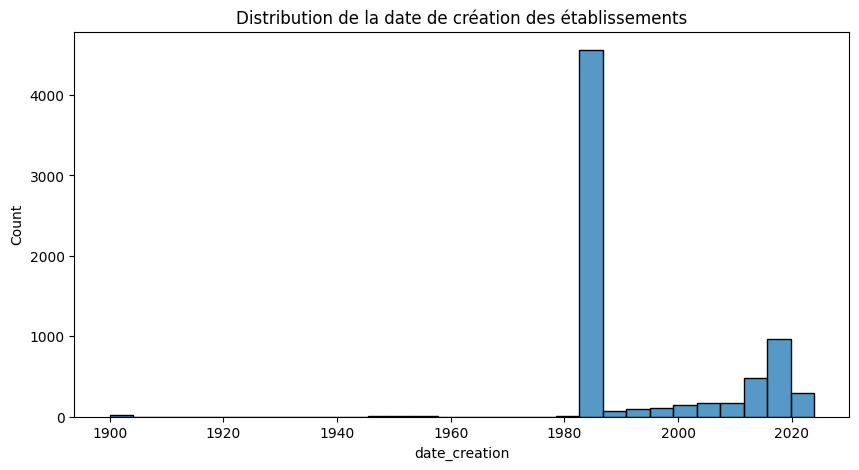

In [15]:
# Visualisation de la distribution de date_creation
plt.figure(figsize=(10,5))
sns.histplot(pd.to_datetime(df["date_creation"], errors="coerce").dropna(), bins=30, kde=False)
plt.title("Distribution de la date de création des établissements")

In [16]:
# Binning pour date_creation
df["date_creation"] = pd.to_datetime(df["date_creation"], errors="coerce")
df["annee_creation"] = df["date_creation"].dt.year

df["annee_creation_bin"] = pd.cut(
    df["annee_creation"],
    bins=[1899, 1980, 1990, 2000, 2010, 2020, 2030],
    labels=["<1980", "80-89", "90-99", "00-09", "10-19", "20+"]
)

### A partir des variables textuelles

In [17]:
# Exploitation des variables textuelles : nom_du_projet et resume_du_projet
def clean_text(s):
    s = s.lower()
    s = re.sub(r"[^\w\s]", " ", s)
    s = re.sub(r"\s+", " ", s)
    return s.strip()

df["resume_clean"] = df["resume_du_projet"].apply(clean_text)
df["nom_clean"] = df["nom_du_projet"].apply(clean_text)

# Définition de mots-clés métiers
keywords = [
    "renovation",
    "energetique",
    "batiment",
    "ecole",
    "eclairage",
    "incendie",
    "mobilite",
    "isolation",
    "chauffage",
    "photovolta",
    "recyclage"
]

# Création de variables binaires
for kw in keywords:
    df[f"kw_{kw}"] = (
        df["resume_clean"].str.contains(kw) |
        df["nom_clean"].str.contains(kw)
    ).astype(int)
# La variable vaut 1 si le mot clé apparaît au moins une fois dans le nom ou dans le résumé du projet

# Suppression des colonnes inutiles après traitement
# Colonnes pas directement exploitables
cols_to_remove = [
    "nom_du_projet",
    "resume_du_projet", 
    "nom_clean", 
    "resume_clean", 
]
df = df.drop(columns=cols_to_remove)

In [18]:
# Exploitation de la variable textuelle : raison_sociale_beneficiaire
# Nettoyage du texte
df["raison_sociale_clean"] = df["raison_sociale_beneficiaire"].apply(clean_text)

# Définition de mots-clés métiers (typologie des bénéficiaires)
keywords_benef = [
    "commune",
    "ville",
    "departement",
    "region",
    "metropole",
    "communaute",
    "syndicat",
    "association",
    "territoires",
    "public"
]

# Création de variables binaires
for kw in keywords_benef:
    df[f"kw_benef_{kw}"] = (
        df["raison_sociale_clean"].str.contains(kw)
    ).astype(int)

# La variable vaut 1 si le mot-clé apparaît dans la raison sociale du bénéficiaire

# Suppression des colonnes inutiles après traitement
cols_to_remove = [
    "raison_sociale_beneficiaire",
    "raison_sociale_clean"
]

df = df.drop(columns=cols_to_remove)

# Vérification finale
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7084 entries, 0 to 8867
Data columns (total 40 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   montant_engage                           7084 non-null   float64       
 1   demarche                                 7084 non-null   category      
 2   nom_region                               7084 non-null   category      
 3   nom_departement                          7084 non-null   category      
 4   code_departement                         7084 non-null   category      
 5   forme_juridique_beneficiaire             7084 non-null   category      
 6   code_commune                             7084 non-null   category      
 7   nom_commune                              7084 non-null   category      
 8   siret                                    7084 non-null   category      
 9   activite_principale                      7084 

# Statistiques descriptives
## Statistiques descriptives univariées
### Variables numériques

In [19]:
# Statistiques descriptives pour les variables numériques continues 
for col in df.select_dtypes('float64').columns:
    display(df[col].describe())

count    7.084000e+03
mean     1.775760e+05
std      3.516024e+05
min      2.875000e+02
25%      1.647065e+04
50%      5.893300e+04
75%      2.000000e+05
max      8.921761e+06
Name: montant_engage, dtype: float64

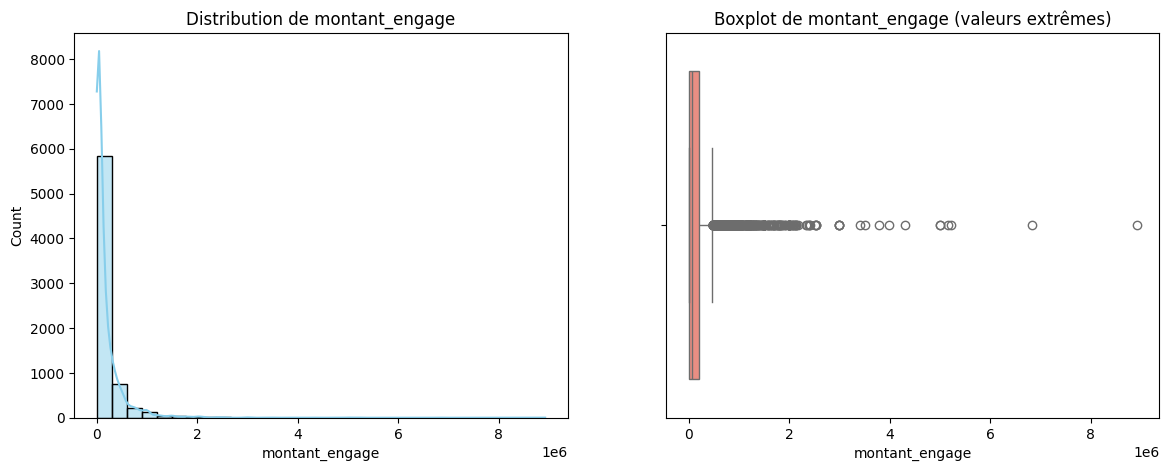

In [20]:
# Distribution et valeurs extrêmes
# Histogramme + Boxplot 
for col in df.select_dtypes('float64').columns:
    fig, axes = plt.subplots(1,2, figsize=(14,5))
    
    # Histogramme
    sns.histplot(df[col], bins=30, kde=True, ax=axes[0], color="skyblue")
    axes[0].set_title(f"Distribution de {col}")
    
    # Boxplot
    sns.boxplot(x=df[col], ax=axes[1], color="salmon")
    axes[1].set_title(f"Boxplot de {col} (valeurs extrêmes)")
    
    plt.show()

# Distribution fortement asymétrique
# Beaucoup de valeurs potentiellement extrêmes dans montant_engage, pouvant influencer les modèles

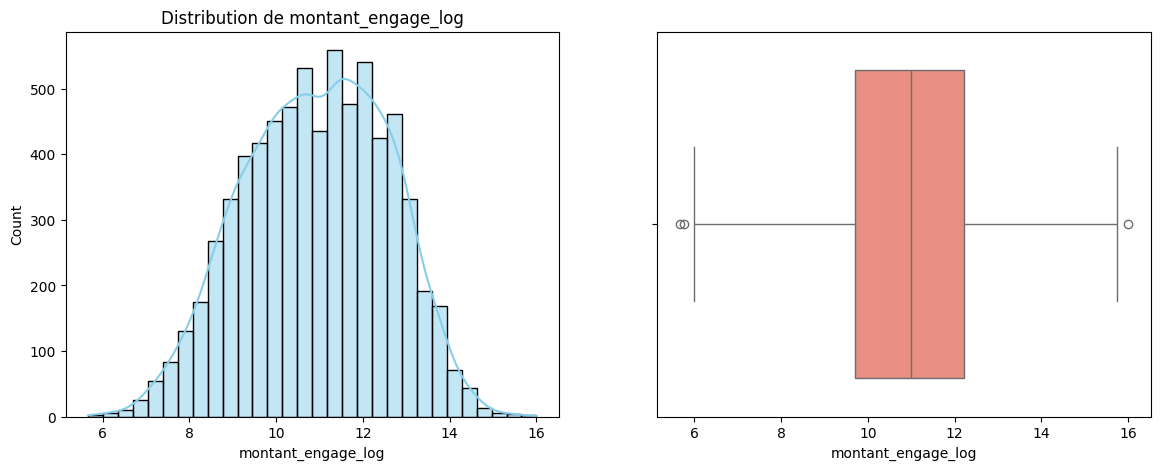

In [21]:
# Transformation logarithmique pour montant_engage
df["montant_engage_log"] = np.log1p(df["montant_engage"])

# Suppression de l'ancienne variable
df = df.drop(columns=["montant_engage"])

# Visualisation après transformation
for col in ["montant_engage_log"]:
    fig, axes = plt.subplots(1,2, figsize=(14,5))
    
    # Histogramme
    sns.histplot(df[col], bins=30, kde=True, ax=axes[0], color="skyblue")
    axes[0].set_title(f"Distribution de {col}")
    
    # Boxplot
    sns.boxplot(x=df[col], ax=axes[1], color="salmon")

# La distribution paraît plus normale et il y a désormais uniquement 3 potentielles valeurs atypiques

Shape après suppression des valeurs extrêmes : (6942, 40)


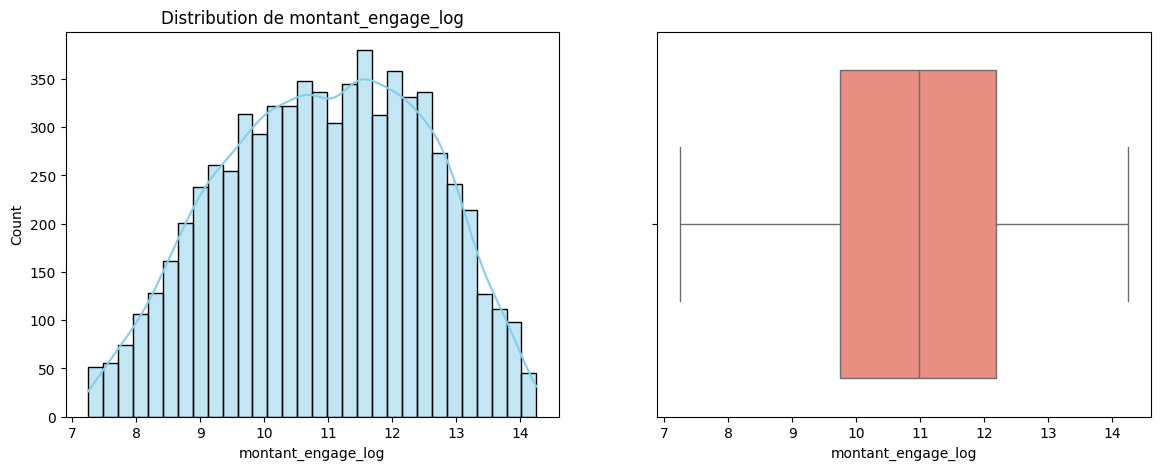

In [22]:
# Traitement des valeurs extrêmes dans montant_engage
# Suppression des 1% valeurs les plus élevées et les 1% les plus basses
lower_bound = df["montant_engage_log"].quantile(0.01)
upper_bound = df["montant_engage_log"].quantile(0.99)
df = df[(df["montant_engage_log"] >= lower_bound) & (df["montant_engage_log"] <= upper_bound)]
print(f"Shape après suppression des valeurs extrêmes : {df.shape}")

# Distribution et valeurs extrêmes après traitement
for col in ["montant_engage_log"]:
    fig, axes = plt.subplots(1,2, figsize=(14,5))
    
    # Histogramme
    sns.histplot(df[col], bins=30, kde=True, ax=axes[0], color="skyblue")
    axes[0].set_title(f"Distribution de {col}")
    
    # Boxplot
    sns.boxplot(x=df[col], ax=axes[1], color="salmon")

# On passe de 5679 à 5567 lignes après suppression des valeurs extrêmes
# 112 lignes supprimées

### Variables catégorielles

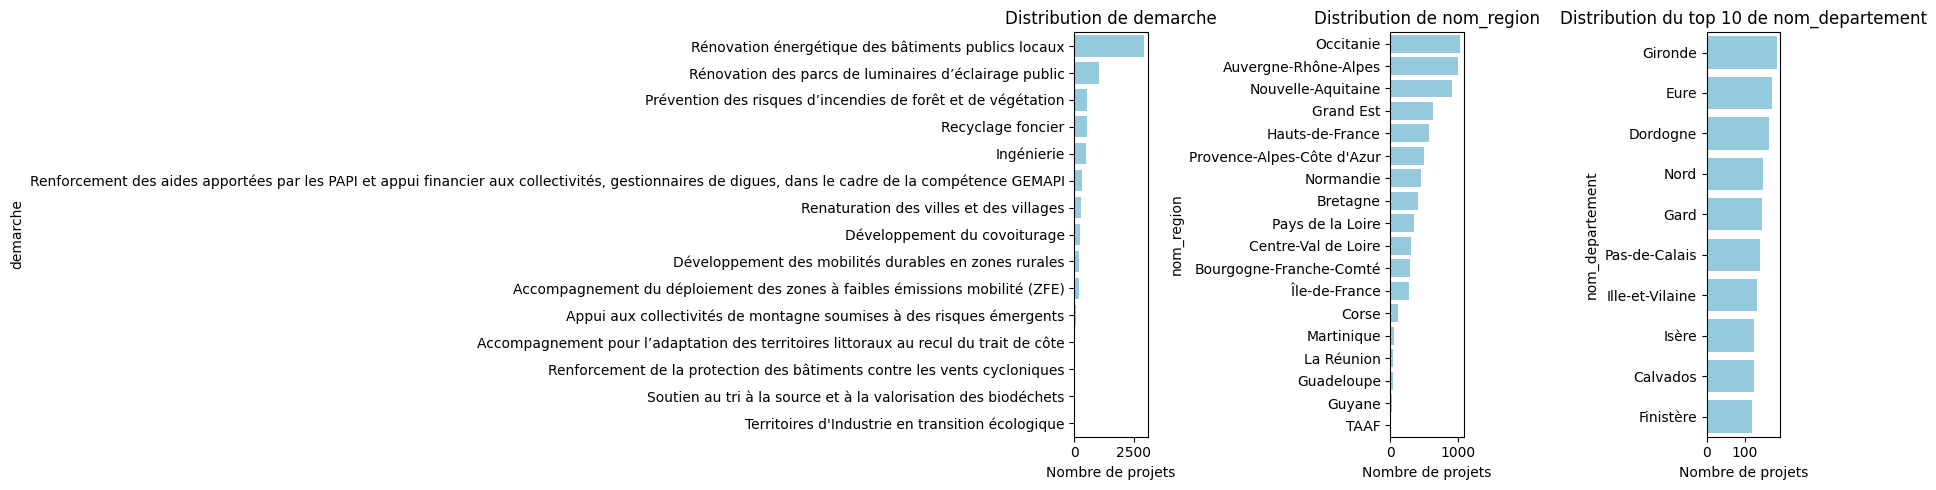

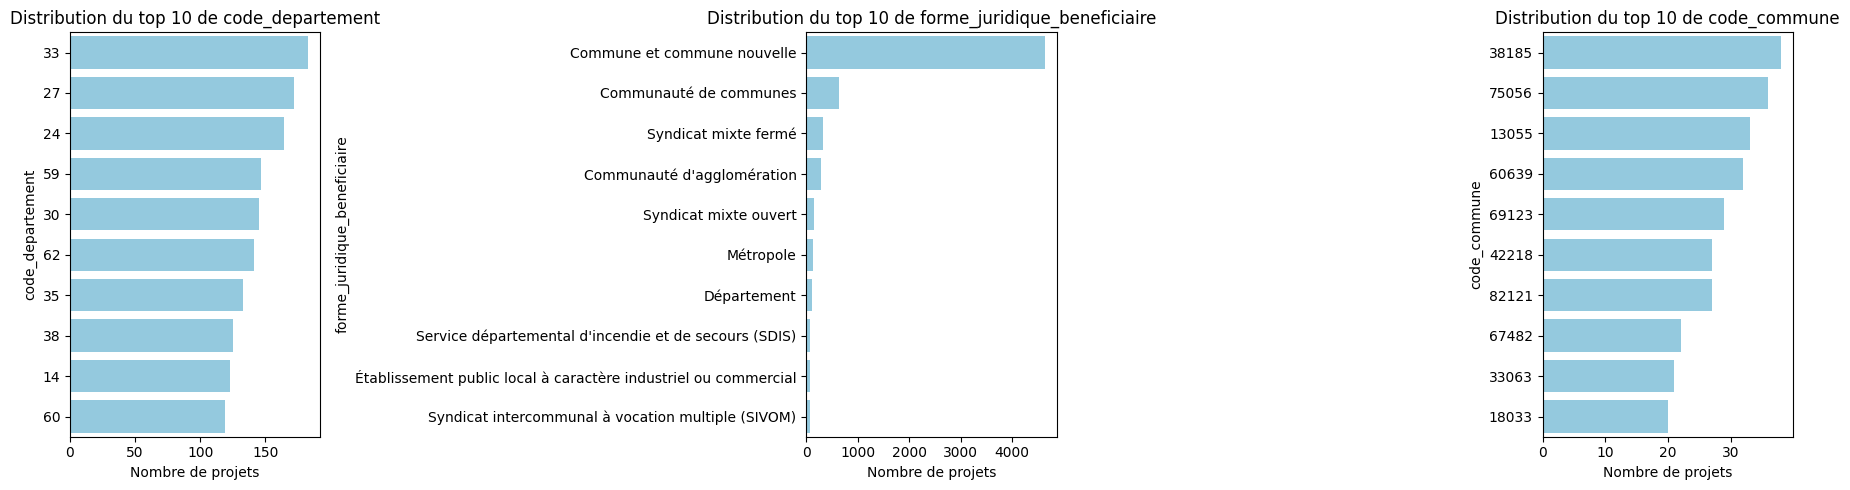

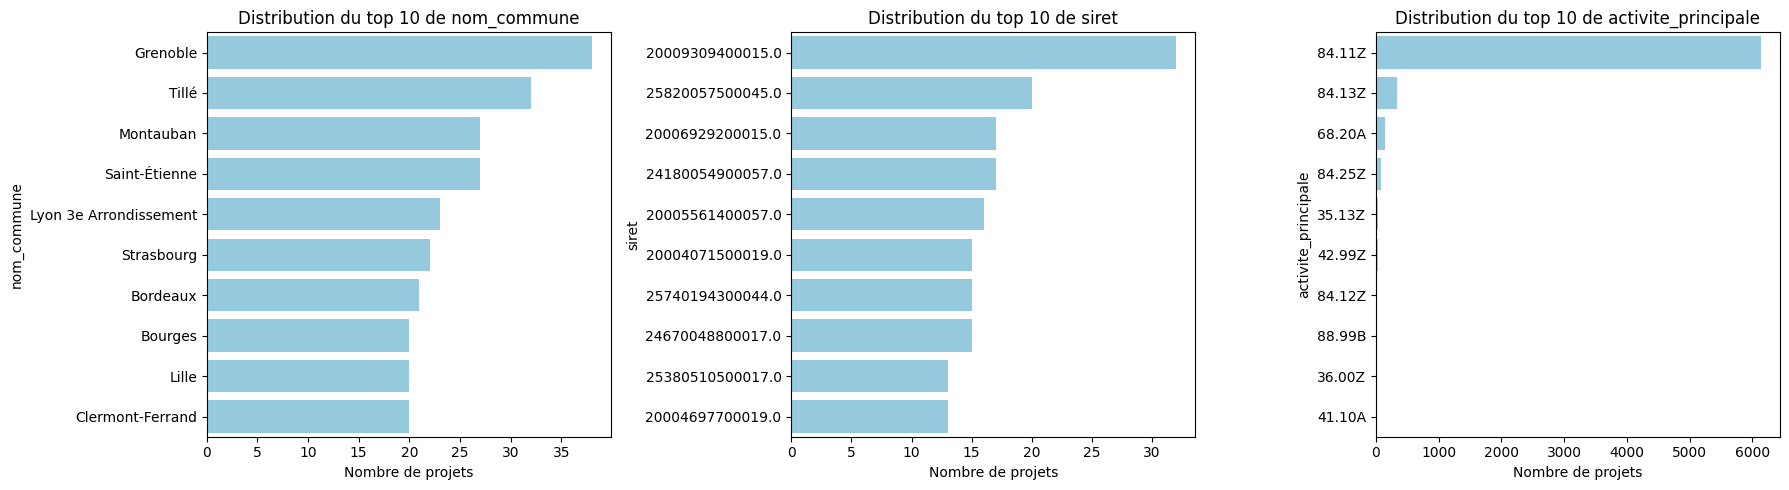

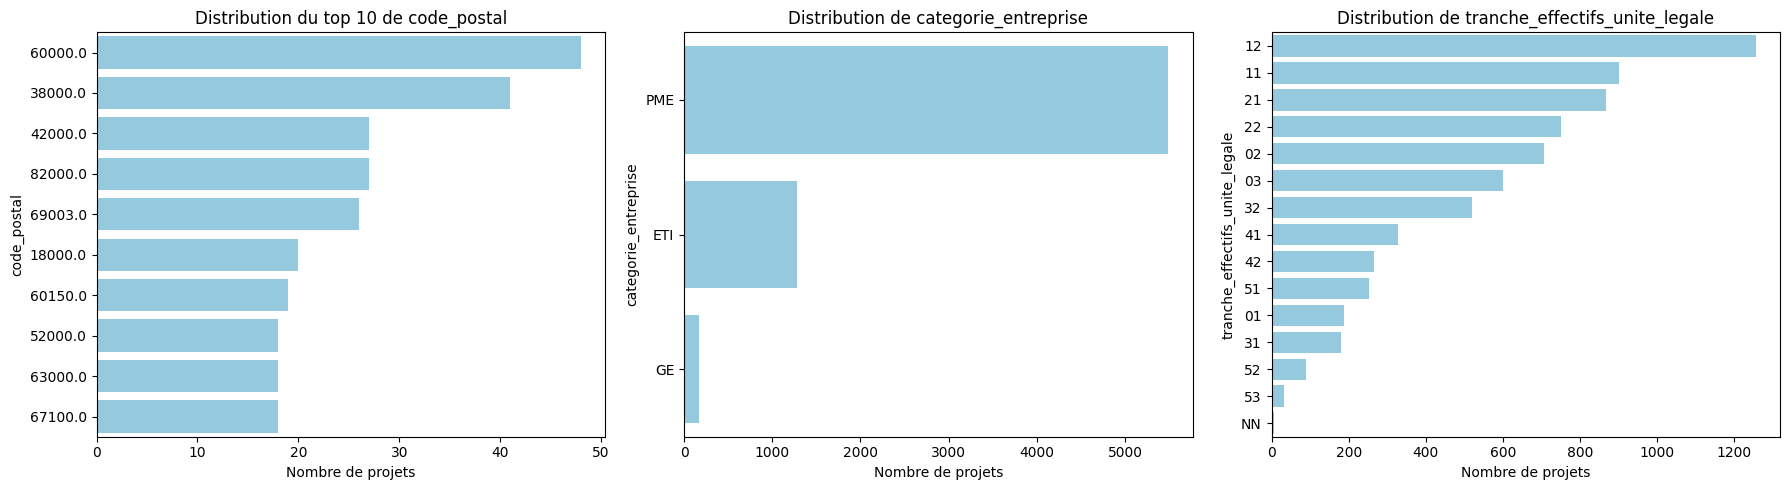

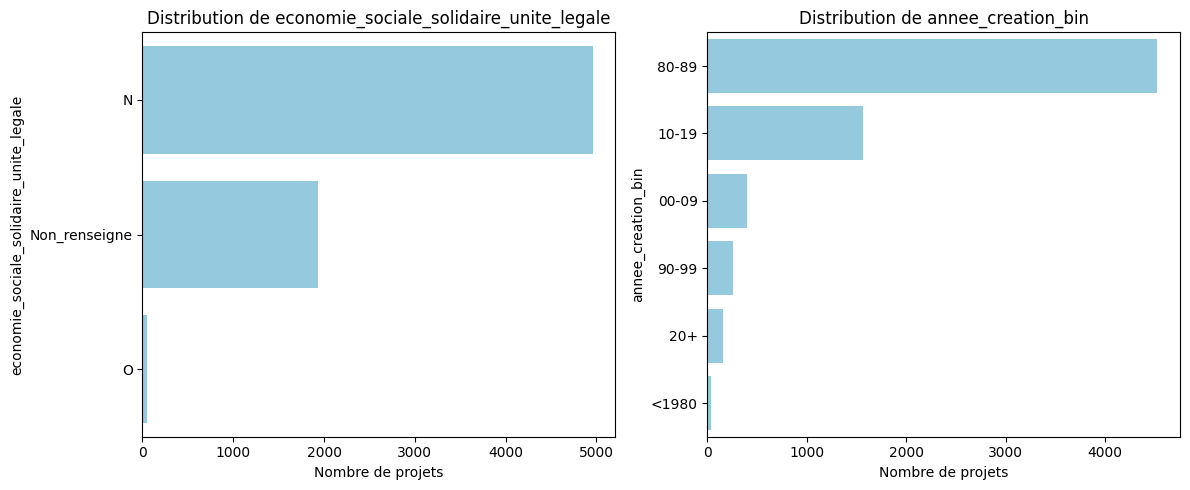

In [23]:
# Distribution des variables catégorielles (subplots)
# Variables catégorielles avec + de 20 modalités
# nom_departement, code_departement, forme_juridique_beneficiaire, code_commune, nom_commune, siret, code_postal, activite_principale

# Variables catégorielles avec - de 20 modalités
# demarche, nom_region, categorie_entreprise, tranche_effectif_unite_legale, economie_sociale_solidaire_unite_legale, nb_projet_siret, annee_creation_bin

cat_cols = df.select_dtypes('category').columns.tolist()
n_cols = 3  # nombre de graphiques par ligne

for i in range(0, len(cat_cols), n_cols):
    cols_slice = cat_cols[i:i+n_cols]
    fig, axes = plt.subplots(1, len(cols_slice), figsize=(6*len(cols_slice), 5))
    
    if len(cols_slice) == 1:
        axes = [axes]
    
    for ax, col in zip(axes, cols_slice):
        vc = df[col].value_counts()
        
        # règle < 20 modalités / >= 20 modalités (dans ce cas, affiche uniquement les 10 modalités les plus présentes)
        if vc.shape[0] < 20:
            order = vc.index
            title = f"Distribution de {col}"
        else:
            order = vc.head(10).index
            title = f"Distribution du top 10 de {col}"
        
        sns.countplot(
            y=col,
            data=df,
            order=order,
            color="skyblue",
            ax=ax
        )
        
        ax.set_title(title, fontsize=12)
        ax.set_xlabel("Nombre de projets")
        ax.set_ylabel(col)
    
    plt.tight_layout()
    plt.show()

# activite_principale pourrait peut-être être transformer en variable à 3 catégories
# Néanmoins, on peut essayer d'exploiter toutes les informations de cette variable dans un premier temps

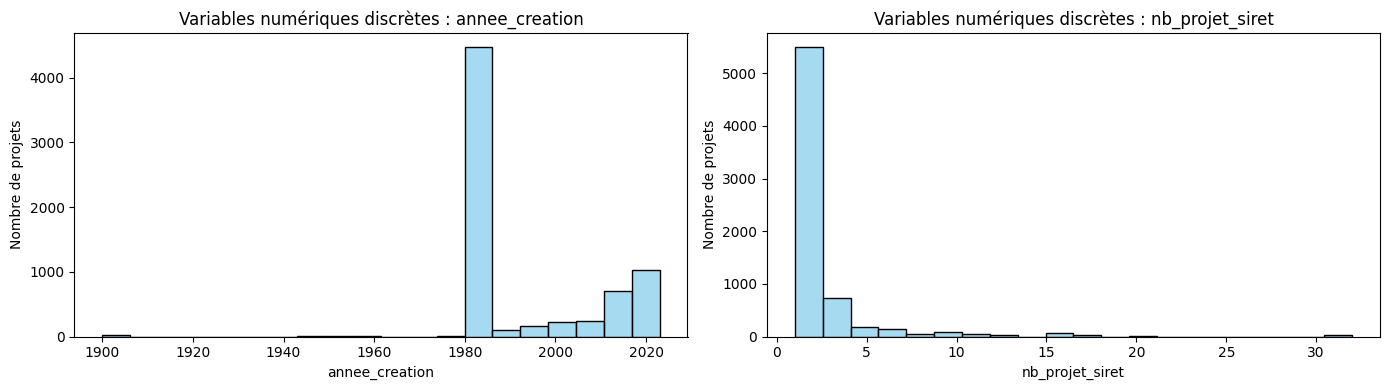

In [24]:
# Fonction générique pour variables numériques discrètes
def plot_int_vars(columns, title_prefix, bins=20):
    """
    columns : liste de noms de colonnes OU un seul nom de colonne (str)
    """
    # Sécurisation si une seule colonne est passée
    if isinstance(columns, str):
        columns = [columns]
    
    n_cols = 2
    n_rows = (len(columns) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 4))
    axes = axes.flatten()
    
    for i, col in enumerate(columns):
        sns.histplot(
            df[col],
            bins=bins,
            kde=False,
            ax=axes[i],
            color="skyblue"
        )
        axes[i].set_title(f"{title_prefix} : {col}", fontsize=12)
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("Nombre de projets")
    
    # Suppression des axes vides
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

plot_int_vars(
    ["annee_creation", "nb_projet_siret"],
    "Variables numériques discrètes"
)

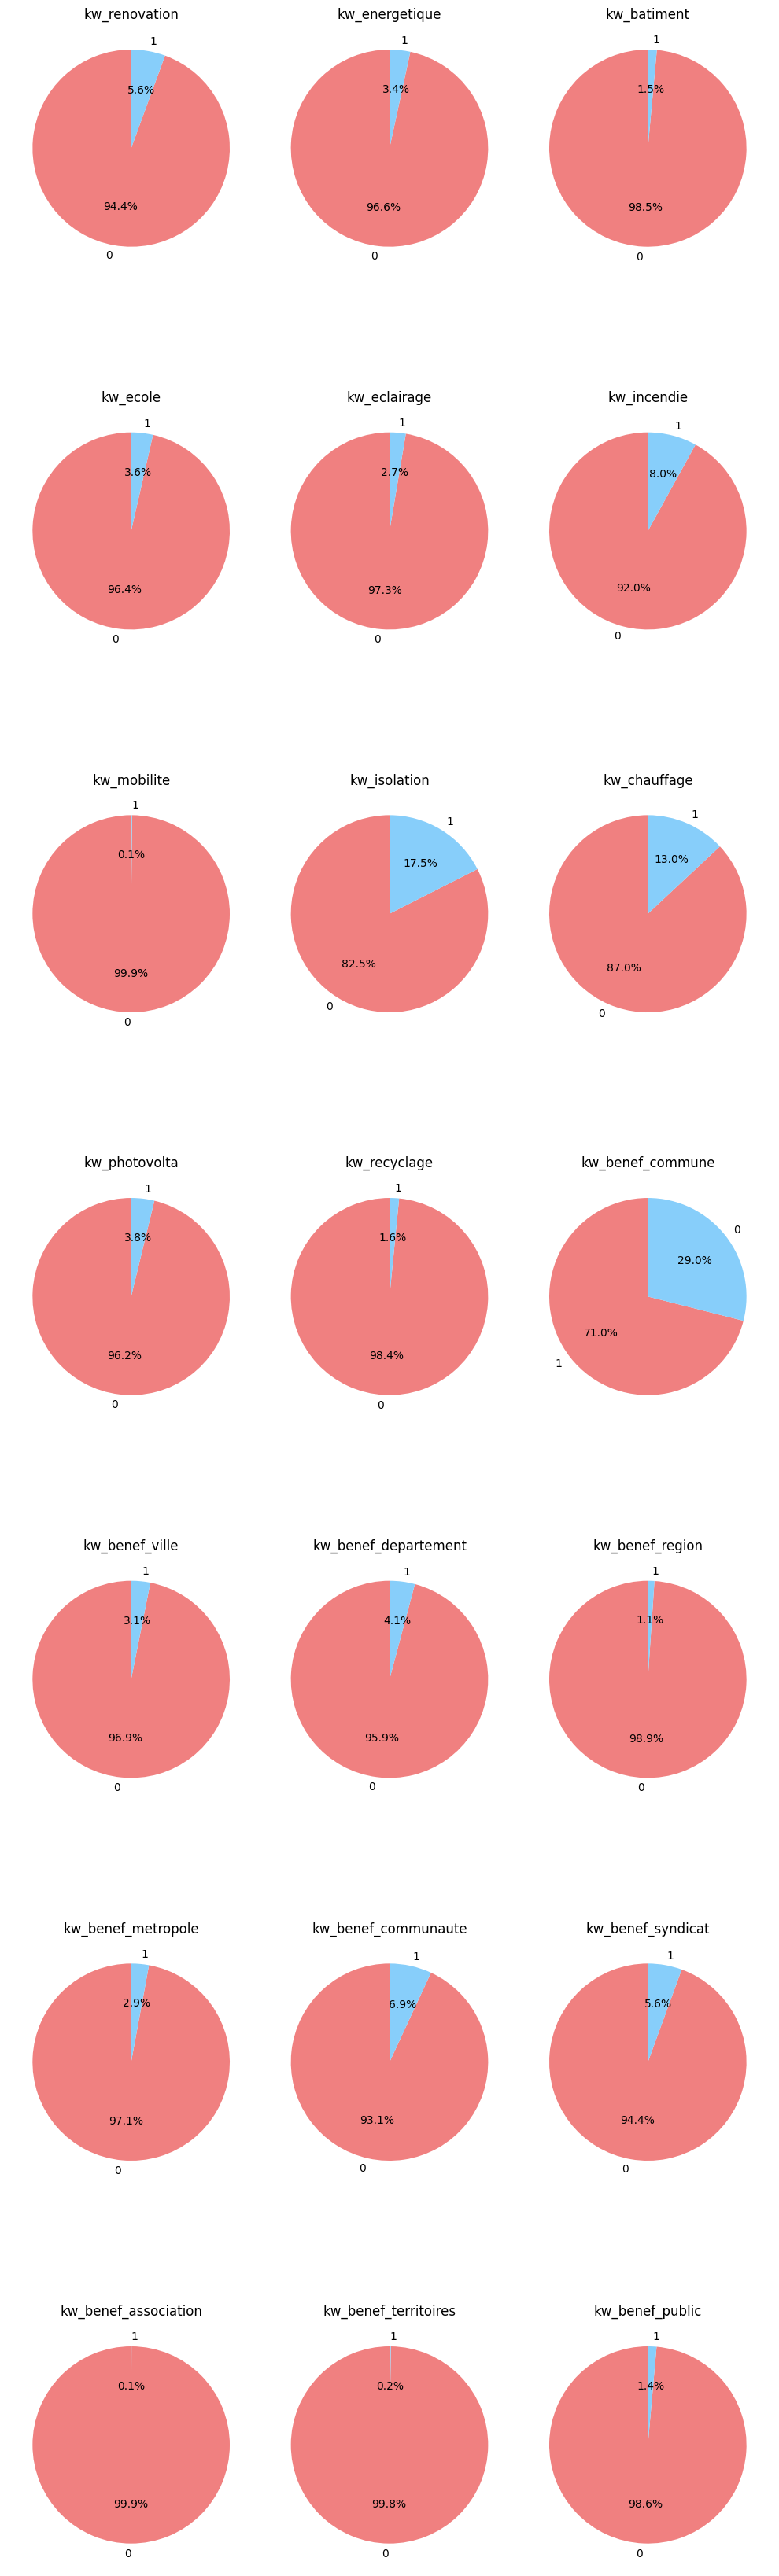

In [25]:
# Variables binaires : int64 avec 2 valeurs possibles
bin_cols = [c for c in df.select_dtypes('int64').columns if df[c].nunique() == 2]

# Fonction pour créer des pie charts pour les variables binaires
def plot_binary_pie(columns):
    n_cols = 3  # nombre de colonnes de graphiques
    n_rows = (len(columns) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, n_rows*5))
    axes = axes.flatten()
    
    for i, col in enumerate(columns):
        counts = df[col].value_counts()
        axes[i].pie(
            counts, 
            labels=counts.index, 
            autopct='%1.1f%%', 
            startangle=90, 
            colors=['lightcoral','lightskyblue']
        )
        axes[i].set_title(f"{col}")
    
    # Supprimer les axes vides
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

# Affichage des pie charts pour toutes les variables binaires
if bin_cols:
    plot_binary_pie(bin_cols)

# kw_benef_commune est la seule variable binaire qui a majoritairement des 1 (71%)
# Certaines variables n'ont que très peu de 1, mais on peut quand même essayer d'exploiter les informations que ça apporte

## Statistiques descriptives bivariées
### Corrélation entre variables explicatives
#### Variables numériques

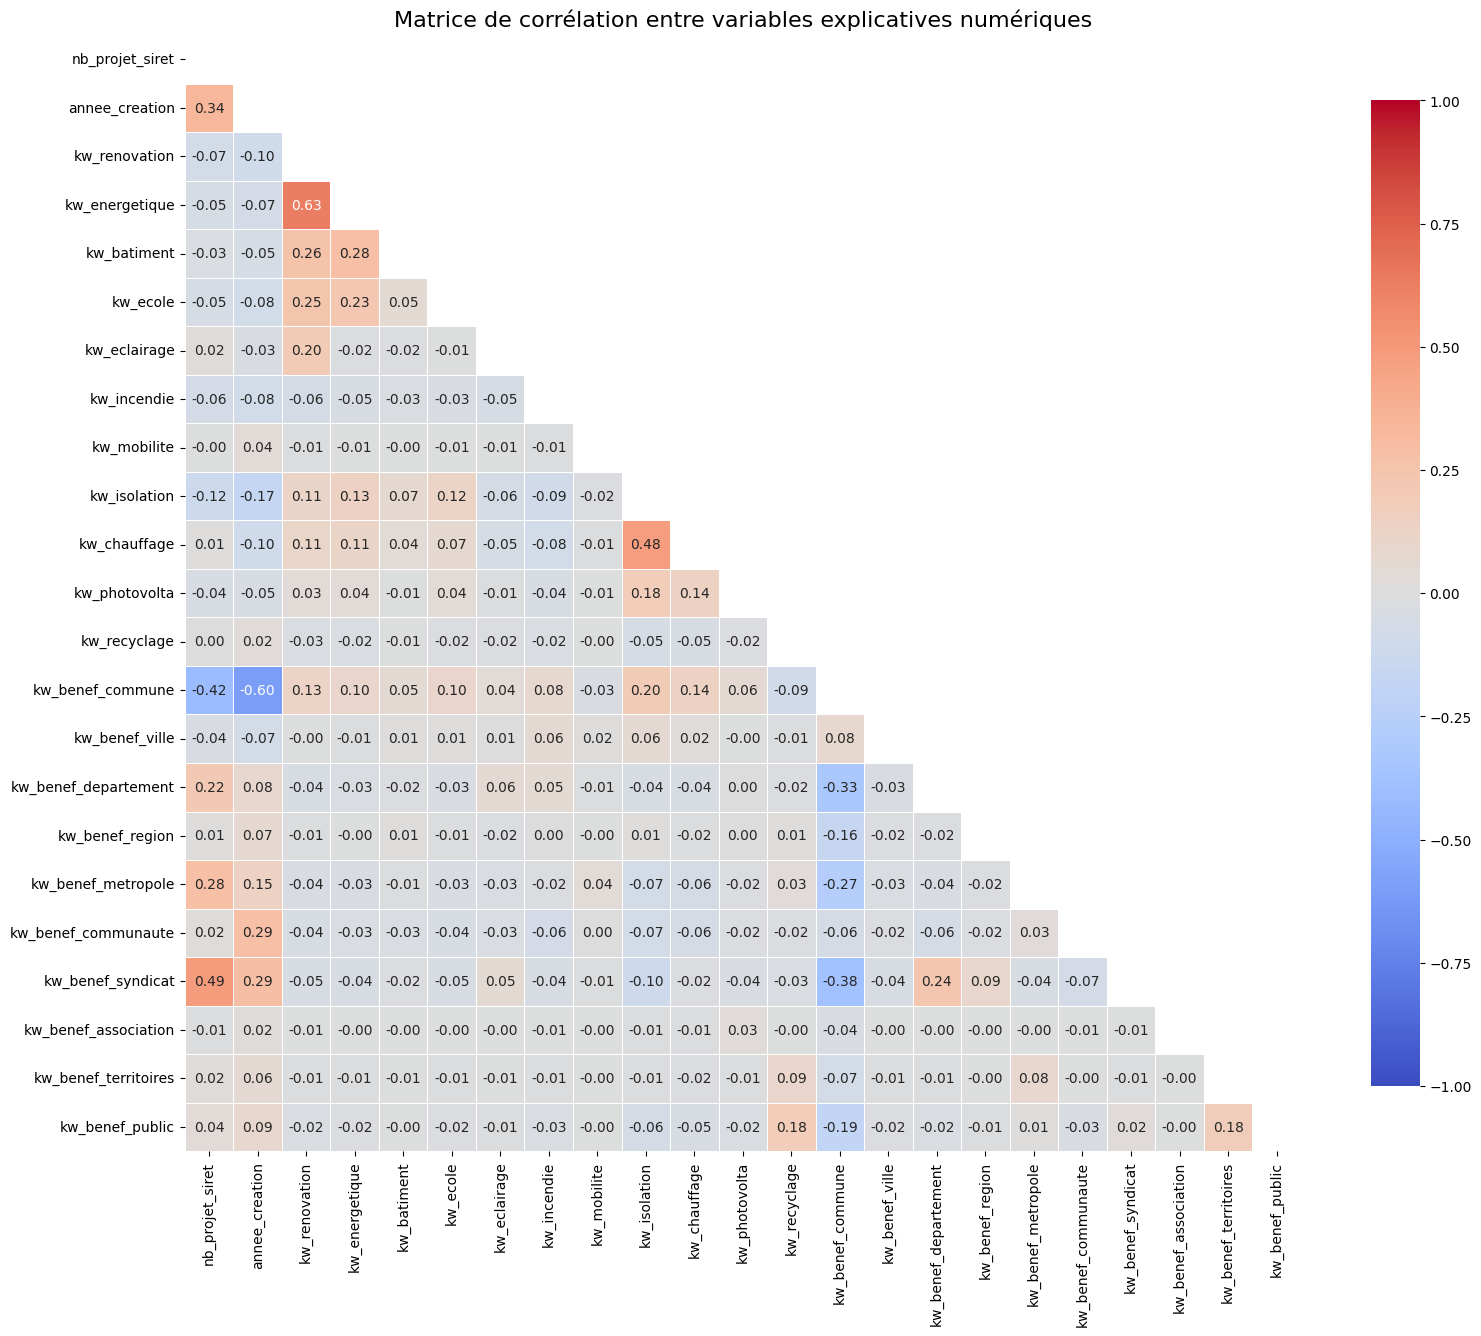

In [26]:
# Sélection des variables numériques explicatives
num_cols = df.select_dtypes(include=["int64", "int32", "float64"]).columns.tolist()
num_cols = [c for c in num_cols if c != "montant_engage_log"]

# Calcul de la matrice de corrélation
corr = df[num_cols].corr()

# Masque triangle supérieur
mask = np.triu(np.ones_like(corr, dtype=bool))

# Heatmap
plt.figure(figsize=(18, 16))
sns.heatmap(
    corr,
    mask=mask,
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    annot=True,
    fmt=".2f"
)
plt.title("Matrice de corrélation entre variables explicatives numériques", fontsize=16)
plt.show()

# Corrélation positive plutôt élevé (0.63) entre kw_energetique et kw_renovation
# Corrélation négative importante (-0.60) entre kw_benef_commune et annee_creation 
# Sinon uniquement des corrélations inférieures à 0.5 en valeur absolue
# On peut noter une corrélation de 0.49 entre kw_benef_syndicat et nb_projet_siret
# Et -0.42 entre nb_projet_siret et kw_benef_commune
# Ainsi qu'une corrélation de 0.48 entre kw_chauffage et kw_isolation

#### Variables qualitatives

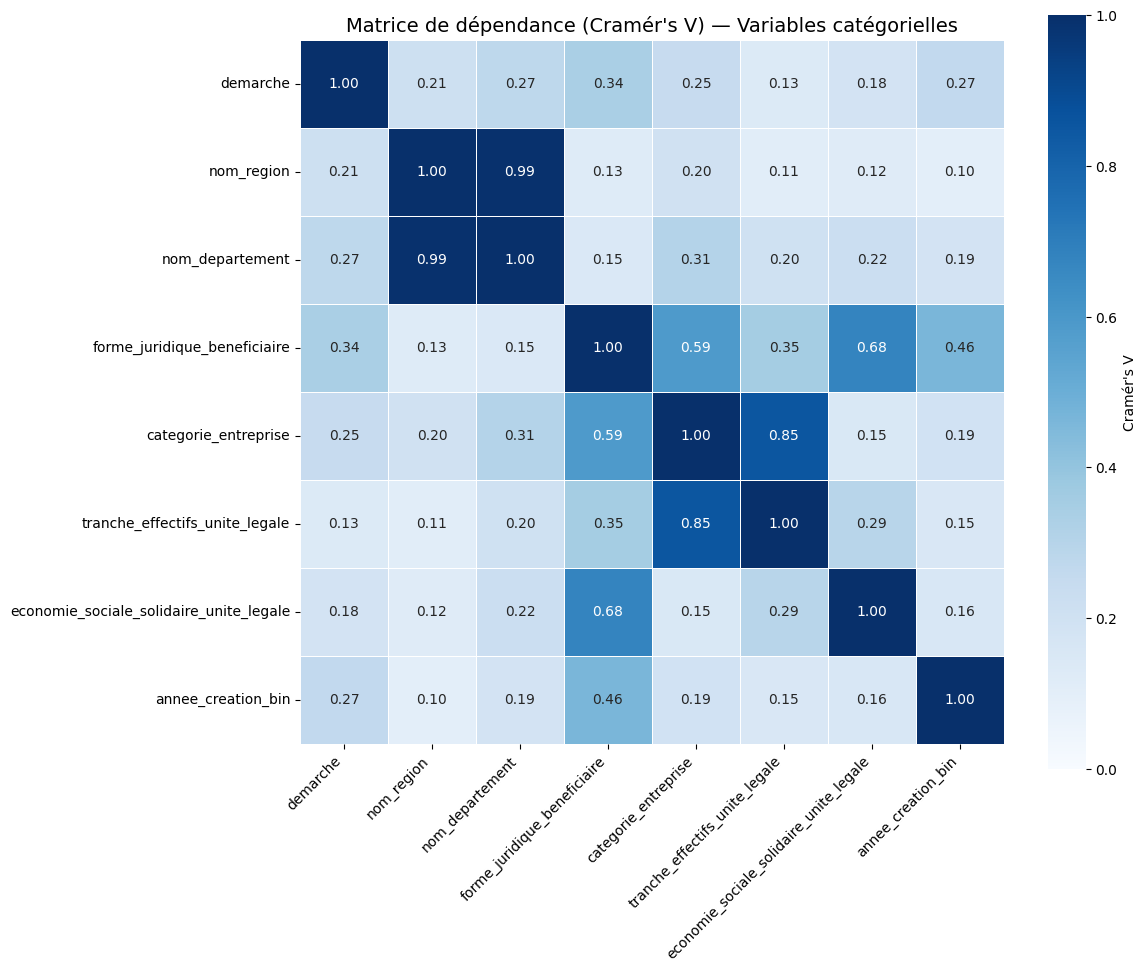

In [27]:
# Matrice de Cramer's V, basée sur le test du Khi deux

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape

    # correction du biais
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)

    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# On exclue les variables avec trop de modalités
cat_cols = [
    "demarche",
    "nom_region",
    "nom_departement",
    "forme_juridique_beneficiaire",
    "categorie_entreprise",
    "tranche_effectifs_unite_legale",
    "economie_sociale_solidaire_unite_legale",
    "annee_creation_bin"
]

cramers_matrix = pd.DataFrame(
    np.zeros((len(cat_cols), len(cat_cols))),
    index=cat_cols,
    columns=cat_cols
)

for col1 in cat_cols:
    for col2 in cat_cols:
        cramers_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])

plt.figure(figsize=(12, 10))

sns.heatmap(
    cramers_matrix,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    vmin=0,
    vmax=1,
    linewidths=0.5,
    square=True,
    cbar_kws={"label": "Cramér's V"}
)

plt.title("Matrice de dépendance (Cramér's V) — Variables catégorielles", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Forte dépendances logiques entre nom_region et nom_departement (0.99)
# Ainsi qu'entre tranche_effectif_unite_legale et categorie_entreprise (0.85)
# 0.68 entre forme_juridique_beneficiaire et economie_sociale_solidaire_unite_legale
# 0.59 entre forme_juridique_beneficiaire et categorie_entreprise
# Sinon, que des scores < 0.5


### Corrélation entre variables explicatives et la variable cible
#### Variables numériques et variables cible

Corrélation avec la variable cible (montant_engage_log) :


,correlation
kw_incendie,-0.176997
kw_isolation,0.153134
kw_eclairage,-0.135002
kw_photovolta,0.127595
kw_benef_syndicat,-0.119281
kw_recyclage,0.110547
kw_benef_metropole,0.090256
kw_ecole,0.089879
kw_benef_commune,-0.088846
kw_chauffage,0.080896


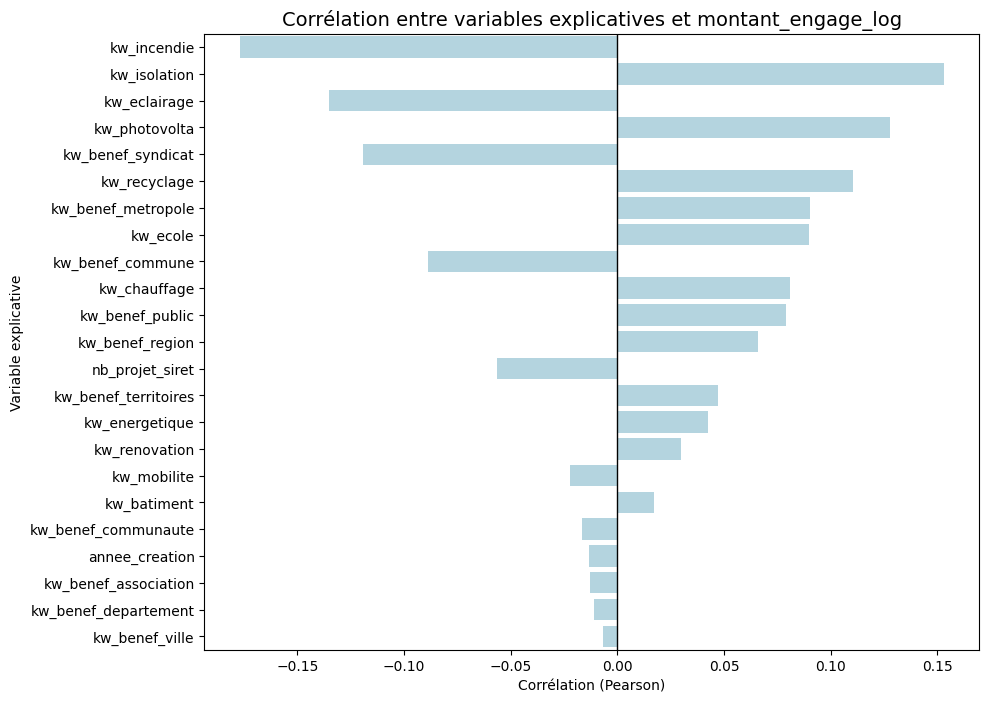

In [28]:
# Corrélation avec la cible
corr_target = (
    df[num_cols + ["montant_engage_log"]]
    .corr()["montant_engage_log"]
    .drop("montant_engage_log")
    .sort_values(key=abs, ascending=False)
)

# Affichage tableau
print("Corrélation avec la variable cible (montant_engage_log) :")
display(corr_target.to_frame(name="correlation"))

# Barplot
plt.figure(figsize=(10, 8))
sns.barplot(
    x=corr_target.values,
    y=corr_target.index,
    color="lightblue"
)
plt.axvline(0, color="black", linewidth=1)
plt.title("Corrélation entre variables explicatives et montant_engage_log", fontsize=14)
plt.xlabel("Corrélation (Pearson)")
plt.ylabel("Variable explicative")
plt.show()


#### Variables catégorielles et variable cible

C:\Users\isali\AppData\Local\Temp\ipykernel_65300\2776135732.py:35: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.



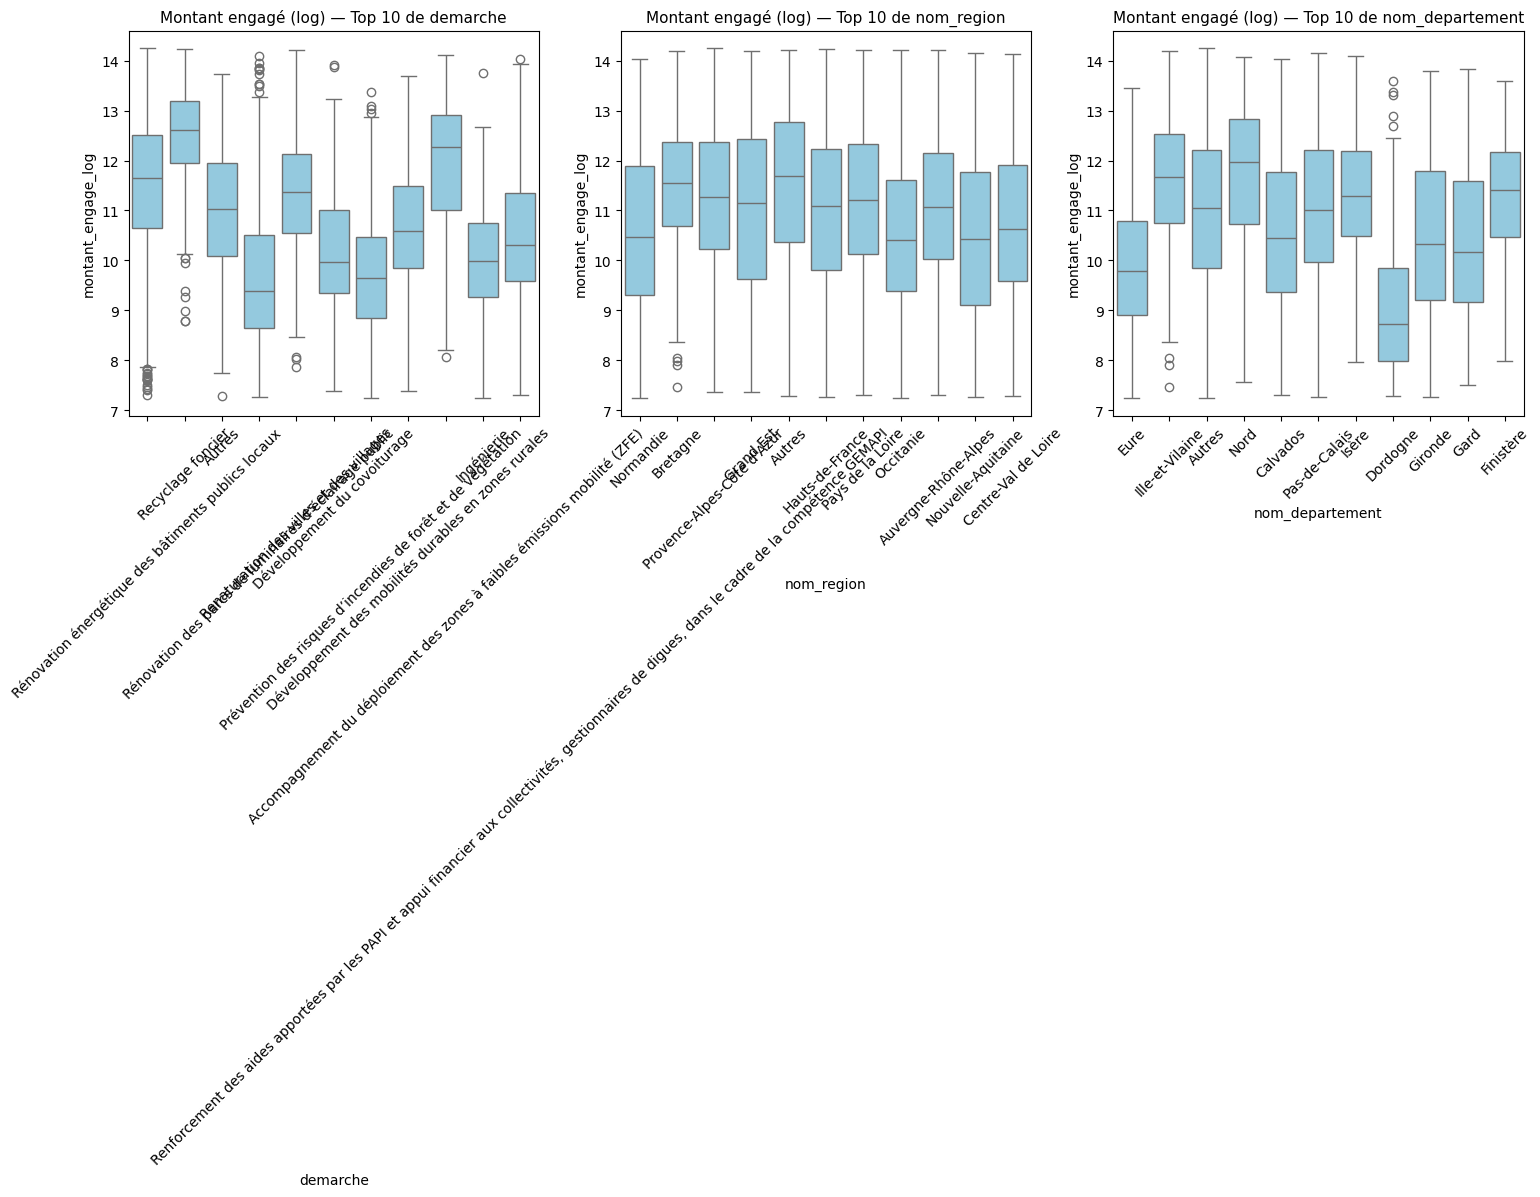

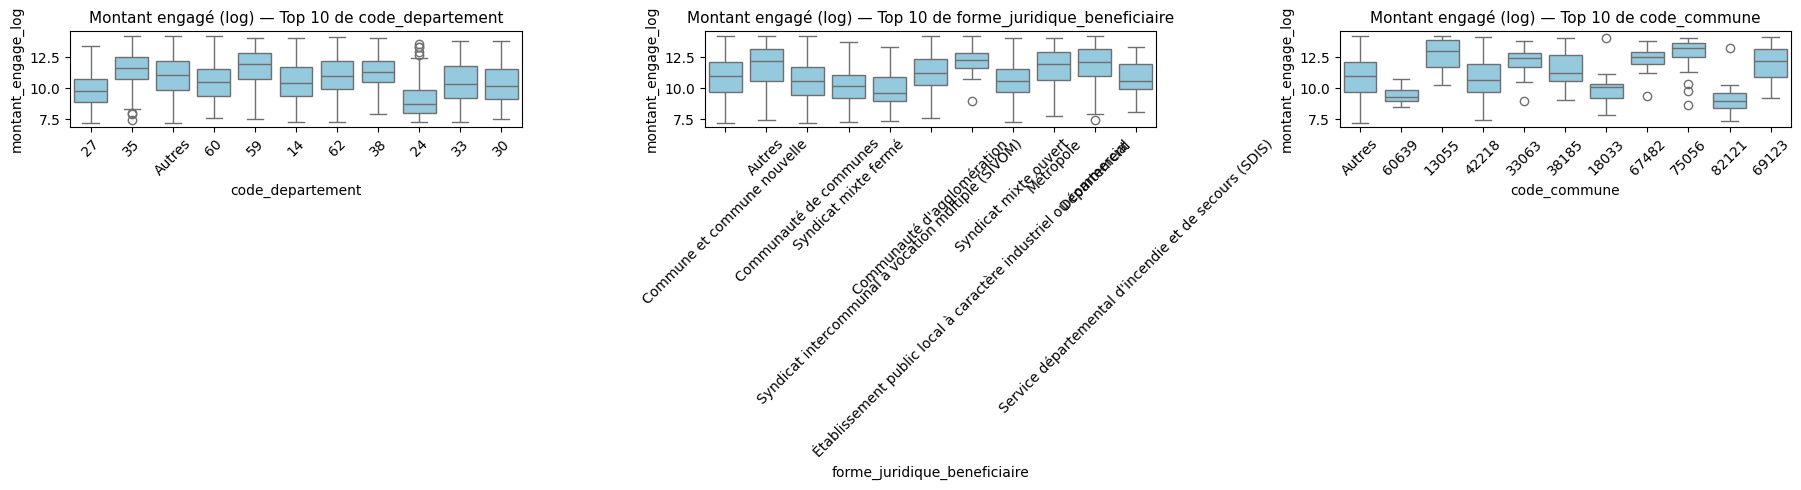

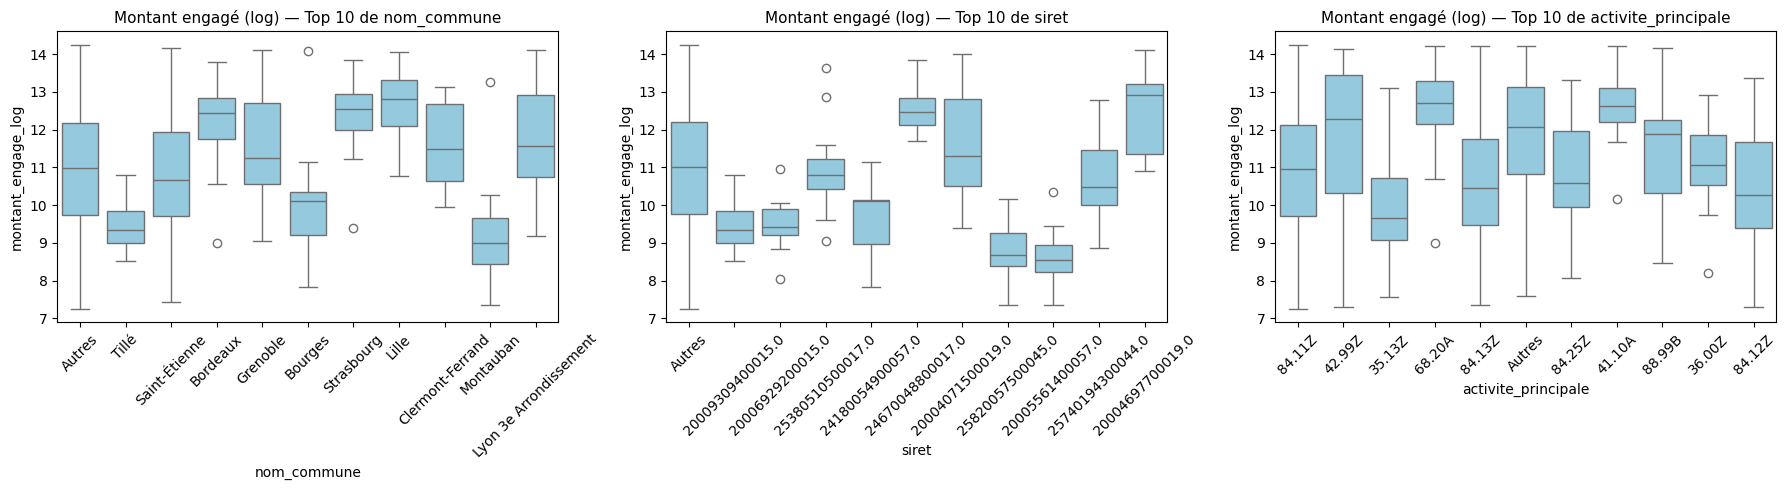

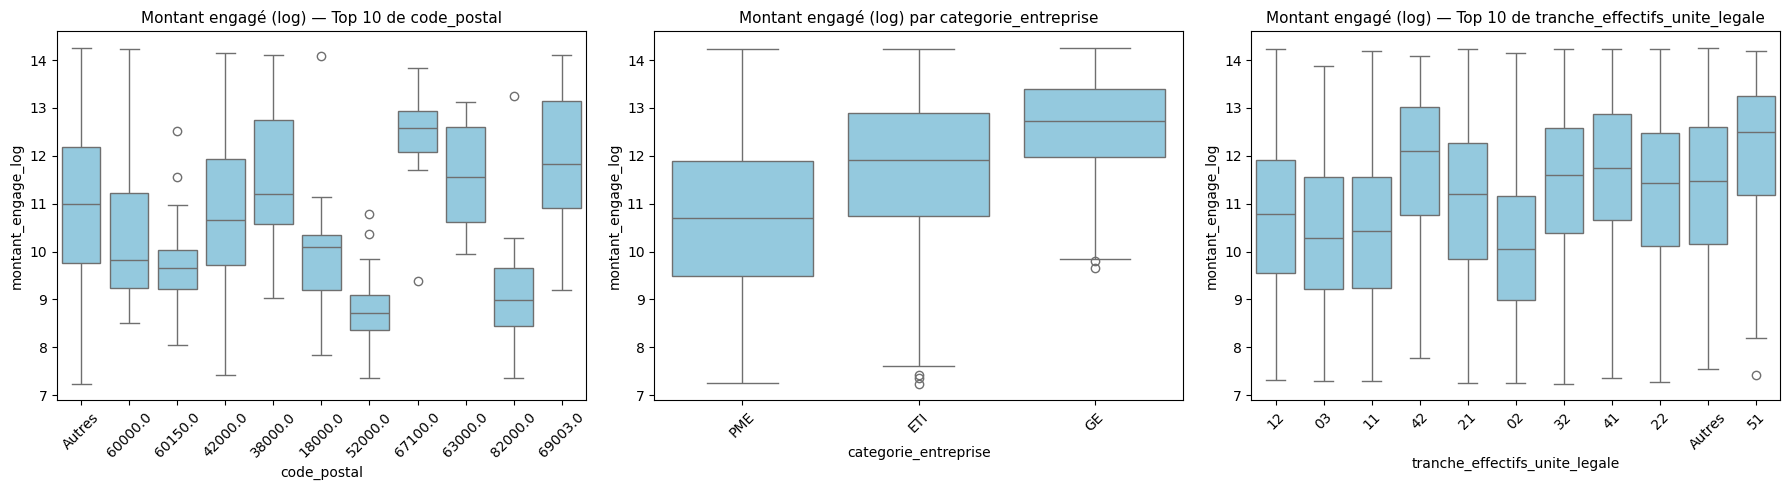

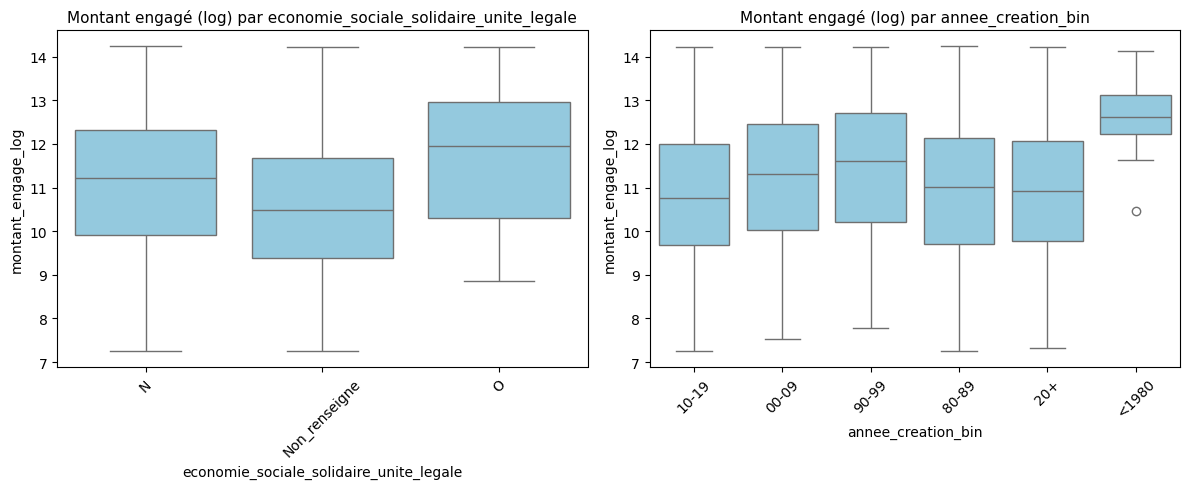

In [29]:
cat_cols = df.select_dtypes("category").columns.tolist()
n_cols = 3 

for i in range(0, len(cat_cols), n_cols):
    cols_slice = cat_cols[i:i+n_cols]
    fig, axes = plt.subplots(1, len(cols_slice), figsize=(6*len(cols_slice), 5))
    
    if len(cols_slice) == 1:
        axes = [axes]
    
    for ax, col in zip(axes, cols_slice):
        vc = df[col].value_counts()

        if vc.shape[0] >= 15:
            top10 = vc.head(10).index.astype(str)
            tmp = df[col].astype(str)
            tmp = tmp.where(tmp.isin(top10), "Autres")
            title = f"Montant engagé (log) — Top 10 de {col}"
        else:
            tmp = df[col].astype(str)
            title = f"Montant engagé (log) par {col}"

        sns.boxplot(
            x=tmp,
            y=df["montant_engage_log"],
            ax=ax,
            color="skyblue"
        )

        ax.set_title(title, fontsize=11)
        ax.set_xlabel(col)
        ax.set_ylabel("montant_engage_log")
        ax.tick_params(axis="x", rotation=45)

    plt.tight_layout()
    plt.show()


# Encodage des variables catégorielles

In [30]:
# Séparation des jeu de données
df_train = df[df["__source__"] == "train"].drop(columns="__source__")
df_test  = df[df["__source__"] == "test"].drop(columns="__source__")
# On fait l'encodage sur train pour éviter le data leakage

In [31]:
# Variable cible
TARGET = "montant_engage_log"

# Colonnes catégorielles
cat_cols = df_train.select_dtypes("category").columns.tolist()

# Séparation selon le nombre de modalités
cat_ohe = [c for c in cat_cols if df_train[c].nunique() <= 3]
cat_target = [c for c in cat_cols if df_train[c].nunique() > 3]

print("Variables en One-Hot Encoding :", cat_ohe)
print("Variables en Target Encoding :", cat_target)

Variables en One-Hot Encoding : ['categorie_entreprise', 'economie_sociale_solidaire_unite_legale']
Variables en Target Encoding : ['demarche', 'nom_region', 'nom_departement', 'code_departement', 'forme_juridique_beneficiaire', 'code_commune', 'nom_commune', 'siret', 'activite_principale', 'code_postal', 'tranche_effectifs_unite_legale', 'annee_creation_bin']


In [32]:
# One Hot Encoding pour les variables catégorielles avec 3 modalités ou moins
ohe = OneHotEncoder(
    sparse_output=False,
    drop=None,
    handle_unknown="ignore"
)

X_ohe = pd.DataFrame(
    ohe.fit_transform(df_train[cat_ohe]),
    columns=ohe.get_feature_names_out(cat_ohe),
    index=df_train.index
)

In [33]:
# Target Encoding pour les variables catégorielles avec plus de 3 modalités
# Permet de conserver l'information
te = TargetEncoder(
    cols=cat_target,
    smoothing=10  # régularisation (important pour éviter l'overfitting)
)

X_te = te.fit_transform(
    df_train[cat_target],
    df_train[TARGET]
)

In [34]:
# Assemblage avec les nouvelles variables
# Variables numériques (hors cible)
num_cols = df_train.select_dtypes(include=["int64", "int32", "float64"]).columns.tolist()
num_cols = [c for c in num_cols if c != TARGET]

X_num = df_train[num_cols]

# Dataset final prêt pour la modélisation
X = pd.concat(
    [X_num, X_ohe, X_te],
    axis=1
)

y = df_train[TARGET]

# Vérification
print("Shape X :", X.shape)
print("Shape y :", y.shape)

encoded_train = pd.concat(
    [X, y],
    axis=1
)

print(encoded_train.head())

encoded_train.to_csv('data/train_clean.csv', index=False)

Shape X : (5567, 41)
Shape y : (5567,)
   nb_projet_siret  annee_creation  kw_renovation  kw_energetique  \
0                2            2016              0               0   
1                3            2010              0               0   
2                4            2017              0               0   
3                1            1999              0               0   
4                2            1983              0               0   

   kw_batiment  kw_ecole  kw_eclairage  kw_incendie  kw_mobilite  \
0            0         0             0            0            0   
1            0         0             0            0            0   
2            0         0             0            0            0   
3            0         0             0            0            0   
4            0         0             0            0            0   

   kw_isolation  ...  code_departement  forme_juridique_beneficiaire  \
0             0  ...          9.910199                     10.869

# Modélisation
## Configuration de X et y 

In [35]:
# Import des données clean et encodées
train = pd.read_csv('./data/train_clean.csv', header=0)
train.head()

,nb_projet_siret,annee_creation,kw_renovation,kw_energetique,kw_batiment,kw_ecole,kw_eclairage,kw_incendie,kw_mobilite,kw_isolation,...,code_departement,forme_juridique_beneficiaire,code_commune,nom_commune,siret,activite_principale,code_postal,tranche_effectifs_unite_legale,annee_creation_bin,montant_engage_log
0,2,2016,0,0,0,0,0,0,0,0,...,9.910199,10.869779,10.799737,10.799737,10.799737,10.895936,10.700273,10.755595,10.851749,9.938420
1,3,2010,0,0,0,0,0,0,0,0,...,11.542900,12.497735,11.665901,11.665901,11.197440,11.582846,11.231038,10.332078,11.208873,12.206078
2,4,2017,0,0,0,0,0,0,0,0,...,11.114604,10.628255,10.890455,10.890455,10.799745,10.895936,10.930182,10.755595,10.851749,9.558037
3,1,1999,0,0,0,0,0,0,0,0,...,11.416493,10.869779,11.104666,11.104666,11.104666,10.895936,11.068322,10.414479,11.462832,12.216122
4,2,1983,0,0,0,0,0,0,0,1,...,11.084299,10.869779,11.240529,11.240529,11.273437,10.895936,11.275062,11.905518,10.900336,13.283209


In [36]:
X_train = train.drop('montant_engage_log', axis=1)
y_train = train['montant_engage_log']

# Vérification
print("Shape X train :", X_train.shape)
print("Shape y train :", y_train.shape)

Shape X train : (5567, 41)
Shape y train : (5567,)


In [37]:
# On reprends le df_test
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1375 entries, 7094 to 8867
Data columns (total 39 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   demarche                                 1375 non-null   category      
 1   nom_region                               1375 non-null   category      
 2   nom_departement                          1375 non-null   category      
 3   code_departement                         1375 non-null   category      
 4   forme_juridique_beneficiaire             1375 non-null   category      
 5   code_commune                             1375 non-null   category      
 6   nom_commune                              1375 non-null   category      
 7   siret                                    1375 non-null   category      
 8   activite_principale                      1375 non-null   category      
 9   code_postal                              13

In [38]:
# Encodage test (réutilisation de celui du train, pour éviter la fuite d'information)
# Encodage One-Hot pour les variables avec 3 modalités ou moins
X_ohe_test = pd.DataFrame(
    ohe.transform(df_test[cat_ohe]),  # on utilise ohe déjà fit sur le train
    columns=ohe.get_feature_names_out(cat_ohe),
    index=df_test.index
)

# Encodage Target pour les variables avec > 3 modalités
X_te_test = te.transform(df_test[cat_target])  # on utilise te déjà fit sur le train

# Variables numériques
num_cols_test = df_test.select_dtypes(include=["int64", "int32", "float64"]).columns.tolist()
# On exclut la cible si elle est présente dans le test
num_cols_test = [c for c in num_cols_test if c != TARGET]
X_num_test = df_test[num_cols_test]

# Assemblage du dataset test
X_test = pd.concat([X_num_test, X_ohe_test, X_te_test], axis=1)

# Vérification
print("Shape X_test :", X_test.shape)
print(X_test.head())

y_test = df_test[TARGET]
encoded_test = pd.concat([X_test, y_test], axis=1)
encoded_test.to_csv('data/test_clean.csv', index=False)

Shape X_test : (1375, 41)
      nb_projet_siret  annee_creation  kw_renovation  kw_energetique  \
7094                1            1983              0               0   
7095                1            1983              0               0   
7096                1            1983              0               0   
7097                1            2013              1               1   
7098                9            2017              0               0   

      kw_batiment  kw_ecole  kw_eclairage  kw_incendie  kw_mobilite  \
7094            0         0             0            0            0   
7095            0         0             0            0            0   
7096            0         0             0            0            0   
7097            1         0             0            0            0   
7098            0         0             0            0            0   

      kw_isolation  ...  nom_departement  code_departement  \
7094             1  ...        10.412582         10.

In [39]:
test = pd.read_csv('./data/test_clean.csv', header=0)
X_test = test.drop('montant_engage_log', axis=1)
y_test = test['montant_engage_log']

# Vérification
print("Shape X test :", X_test.shape)
print("Shape y test :", y_test.shape)

Shape X test : (1375, 41)
Shape y test : (1375,)


## Arbres de décisions

In [ ]:

# max_depth : profondeur maximale de l'arbre
# min_samples_split : nombre minimal d'observations pour pouvoir spliter un noeud
# min_samples_leaf : nombre minimal d'observations pour pouvoir créer un noeud
# splitter : critère de split
# random_state : graine pour la reproductibilité

# On instancie notre modèle
tree = DecisionTreeClassifier(
    max_depth=3,
    min_samples_split=2,
    min_samples_leaf=1,
    splitter='best',
    random_state=42,
    )

# On entraine notre modèle
tree.fit(X_train, y_train)

# On prédit les valeurs de y pour X_test
y_pred = tree.predict(X_test)

In [ ]:
# On affiche l'arbre
plt.figure(figsize=(20,10))
plot_tree(tree, filled=True, feature_names=X_train.columns)
plt.show()

In [ ]:
print("score :",tree.score(X_test, y_test))

# On crée une matrice de confusion
cm = confusion_matrix(y_test, y_pred)
print("Matrice confusion : \n",cm)

# On affiche le rapport de classification
print(classification_report(y_test, y_pred))

## Random Forest

## XGBoost